# Recurrent Neural Networks
This assignment aims to implement a simple LSTM from scratch using PyTorch.



This part will focus on RNN. In this part, you will learn how to prepare the data, define the model, train and test your model. In this part, you are asked to finish several tasks and report your results. Similar to CNN, you can also use Google Colab.

**Overview:**
- Implement a 1-layer LSTM from scratch using PyTorch
- Train and test the model on the provided dataset
- Implement the built-in 1-layer LSTM and conduct the training pipeline
- Implement the built-in 1-layer GRU and conduct the training pipeline
- Compare the three models implemented

## 1 - Import Python Packages

Run the following cell to import necessary packages for this part.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import time
from sklearn.metrics import mean_squared_error

## 2 - Data Processing

The following code will load the raw data stored in the specified ``csv`` file and inspect the overall data format. The machine learning task for this assignment is predicting stock's closing price of the next day given the prices from the previous. Therefore, our input should be a sequence of closing prices of the stock, and the output is the closing price of the next day.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive/AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(os.path.join('data', filepath))
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


Plot the raw data.

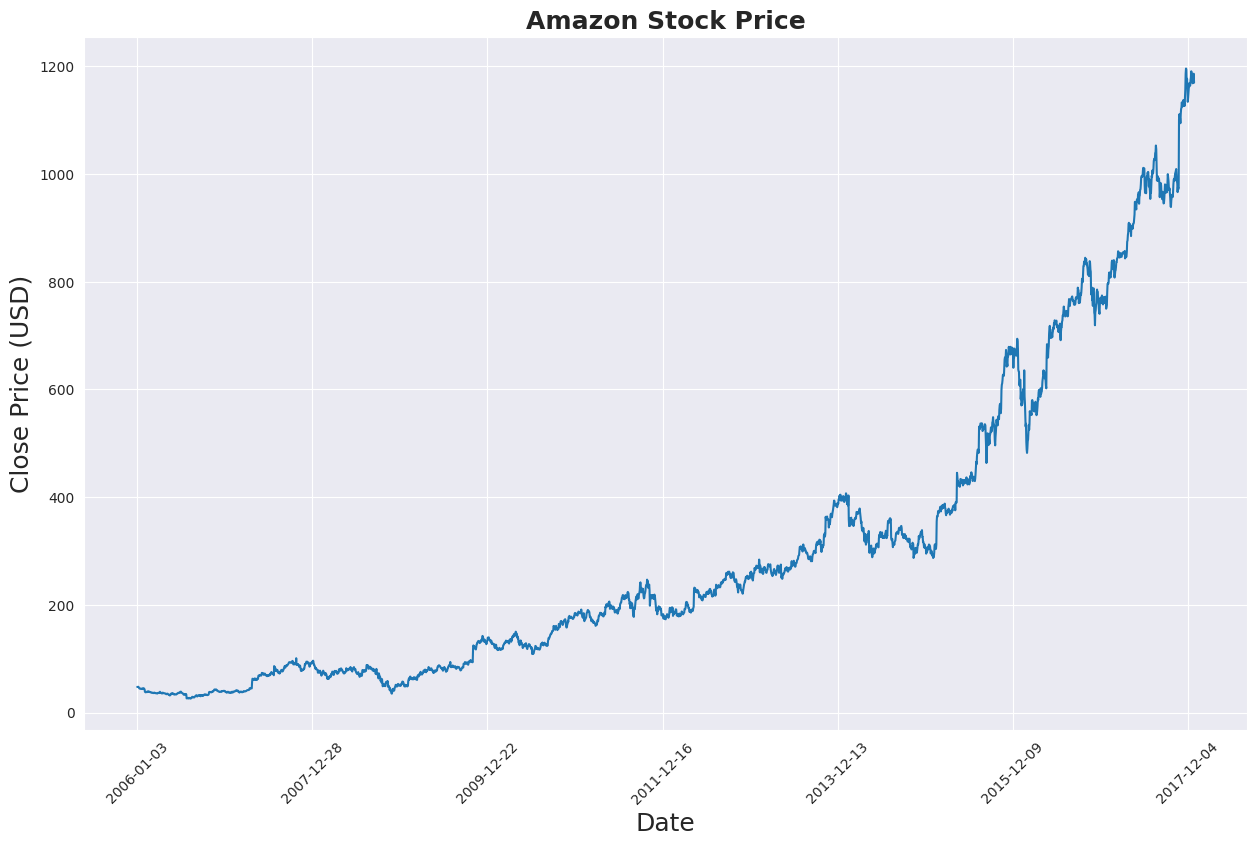

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


For this assignment, we focus on the closing price, so we extract the ``Close`` column in the data frame as our data.

In [ ]:
price = data[['Close']]
price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


Then, we normalize the raw data into the range of ``[-1, 1]``.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


<ipython-input-6-33ec0e5dddec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [ ]:
# process the raw data
lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)

#### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


Convert from ``numpy.array`` to ``torch.tensor``.

In [ ]:
# Convert to torch Tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [ ]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100
learning_rate = 0.01


## 3 - Define the Model [25 points]

Next, we will implement an LSTM cell using only PyTorch's ``torch.nn.Linear`` layer and some appropriate activation functions. Below is the formula of now to calculate different gates, the hidden state and the cell state for timestep ``t`` given the hidden state and the cell state from ``t-1`` and the input from ``t``. You can also refer to the official PyTorch's documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for more details.

Input gate: $i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$

Forget gate: $f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$

Cell gate: $g_t = \text{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})$

Output gate: $o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$

Cell state: $c_t = f_t \odot c_{t-1} + i_t \odot g_t$

Hidden state: $h_t = o_t \odot \text{tanh}(c_t)$

where $\sigma$ denotes the sigmoid function and $\odot$ is the Hadamard product.

In [ ]:
class LSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, bias=True):
        super(LSTMCell, self).__init__()

        # Fill in the following lines
        self.Wii = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.Whi = nn.Linear(hidden_dim, hidden_dim, bias=bias)

        self.Wif = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.Whf = nn.Linear(hidden_dim, hidden_dim, bias=bias)

        self.Wig = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.Whg = nn.Linear(hidden_dim, hidden_dim, bias=bias)

        self.Wio = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.Who = nn.Linear(hidden_dim, hidden_dim, bias=bias)

    def forward(self, x, h, c):
        # Fill in the following lines
        it = torch.sigmoid(self.Wii(x) + self.Whi(h))
        ft = torch.sigmoid(self.Wif(x) + self.Whf(h))
        gt = torch.tanh(self.Wig(x) + self.Whg(h))
        ot = torch.sigmoid(self.Wio(x) + self.Who(h))
        ct = ft * c + it * gt
        ht = ot * torch.tanh(ct)

        return ht, ct


Now, use the above implemented LSTM cell to implement a 1-layer LSTM network. Note that we use the output embedding of the last timestep as the input to a linear layer that predicts the stock price. Here, we can see the LSTM cell as the feature extractor, with the linear layer being the regressor.

**Note:** Don't forget to initialize the hidden and cell state at timestep 0. In standard practice, they are both zero vectors.

In [ ]:
class LSTMNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim

        # Fill in the following 2 lines
        self.lstm_cell = LSTMCell(input_dim, hidden_dim, bias=bias)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        device = x.device
        batch_size, seq_len, _ = x.size()
        # Define the initial hidden and cell states
        ht = torch.zeros(batch_size, self.hidden_dim).to(device)
        ct = torch.zeros(batch_size, self.hidden_dim).to(device)

        # Use a for-loop to define the forward pass of the LSTM network
        for t in range(seq_len):
            ht, ct = self.lstm_cell(x[:, t, :], ht, ct)
        # Use the output embedding of the last timestep as the input to the linear layer
        output = self.fc(ht)


        return output


## 4 -  Training and Testing

In this section, we conduct the training and testing of the LSTM network on the stock prediction task. First, define the model, loss function and optimizer. Note that it is a regression task, so the standard loss function is Mean Squared Error. For the optimizer, we can use the Adam optimizer.

In [ ]:
# remember to send the model's weights to the appropriate device (GPU or CPU)
model = LSTMNet(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Run the code below to conduct the training of the model.

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.5445249676704407
Epoch  1 MSE:  0.07556162029504776
Epoch  2 MSE:  0.14871501922607422
Epoch  3 MSE:  0.11686313897371292
Epoch  4 MSE:  0.04862179234623909
Epoch  5 MSE:  0.024141840636730194
Epoch  6 MSE:  0.027203945443034172
Epoch  7 MSE:  0.037422534078359604
Epoch  8 MSE:  0.04360378906130791
Epoch  9 MSE:  0.042811281979084015
Epoch  10 MSE:  0.03686724230647087
Epoch  11 MSE:  0.02900801971554756
Epoch  12 MSE:  0.022049712017178535
Epoch  13 MSE:  0.017686791718006134
Epoch  14 MSE:  0.016336210072040558
Epoch  15 MSE:  0.01725473254919052
Epoch  16 MSE:  0.01892481930553913
Epoch  17 MSE:  0.019717643037438393
Epoch  18 MSE:  0.018617883324623108
Epoch  19 MSE:  0.015629621222615242
Epoch  20 MSE:  0.011651705019176006
Epoch  21 MSE:  0.007969070225954056
Epoch  22 MSE:  0.005677714012563229
Epoch  23 MSE:  0.0052439370192587376
Epoch  24 MSE:  0.00620344839990139
Epoch  25 MSE:  0.007078899536281824
Epoch  26 MSE:  0.00618824502453208
Epoch  27 MSE:  0.00354

Plot the training predictions along with the losses through time (epochs).

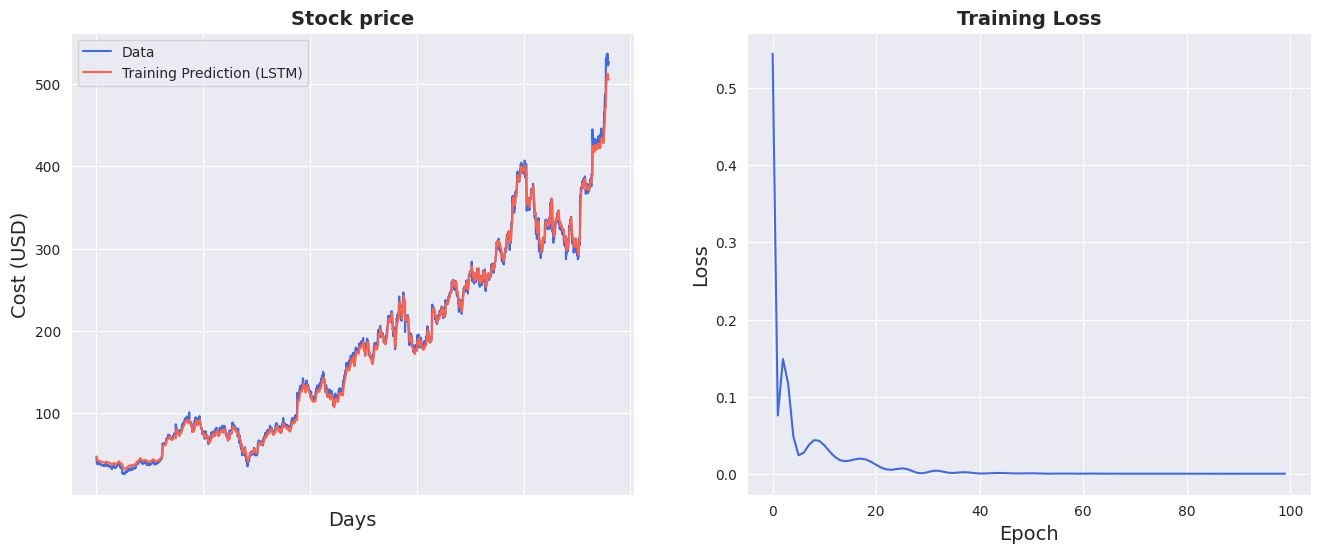

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


Make predictions on the testing set. Plot the training predictions through time (epochs).

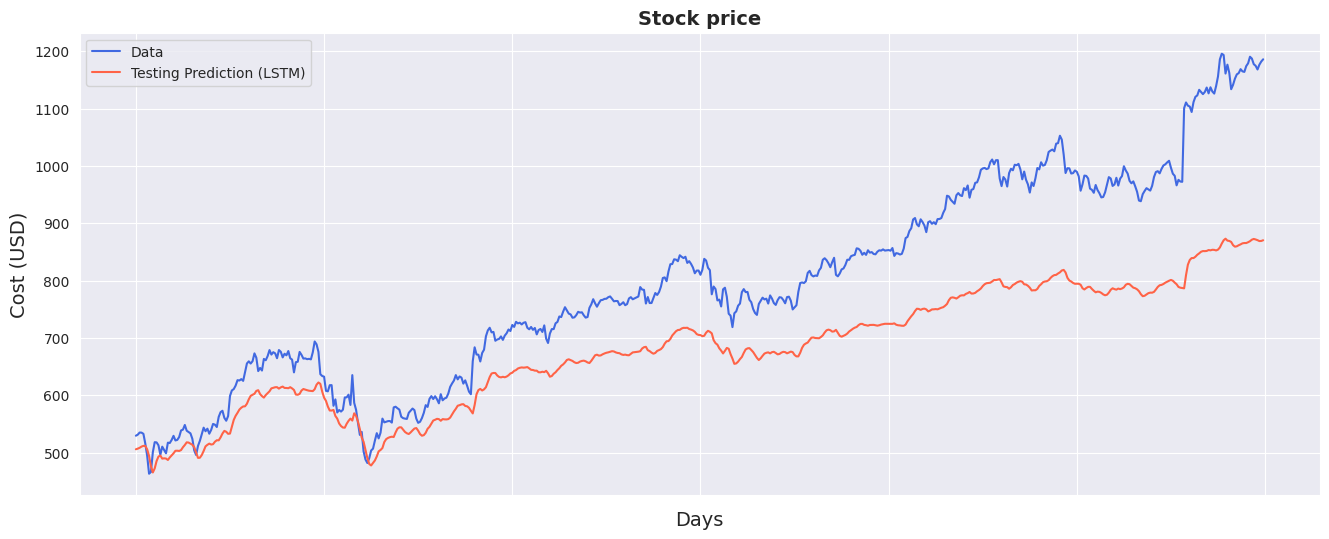

In [ ]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)


Calculate the MSE on both the training and testing data.

In [ ]:
# calculate root mean squared error
y_train = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.01 RMSE
Test Score: 0.24 RMSE


## 5 - Built-in LSTM

Use the provided code snippets and train a 1-layer LSTM network using the PyTorch built-in LSTM cell. Please show the prediction plots as well as the MSE on both training and testing data.

LSTM Epoch 1/100, MSE: 0.6277458667755127


<ipython-input-18-69f42f3806a4>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
<ipython-input-18-69f42f3806a4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)


LSTM Epoch 2/100, MSE: 0.38587987422943115
LSTM Epoch 3/100, MSE: 0.1532583385705948
LSTM Epoch 4/100, MSE: 0.09250618517398834
LSTM Epoch 5/100, MSE: 0.022249648347496986
LSTM Epoch 6/100, MSE: 0.03386082500219345
LSTM Epoch 7/100, MSE: 0.04209887236356735
LSTM Epoch 8/100, MSE: 0.035583049058914185
LSTM Epoch 9/100, MSE: 0.024769112467765808
LSTM Epoch 10/100, MSE: 0.021101107820868492
LSTM Epoch 11/100, MSE: 0.02686513029038906
LSTM Epoch 12/100, MSE: 0.03091728314757347
LSTM Epoch 13/100, MSE: 0.026484448462724686
LSTM Epoch 14/100, MSE: 0.020466398447752
LSTM Epoch 15/100, MSE: 0.019009696319699287
LSTM Epoch 16/100, MSE: 0.021060457453131676
LSTM Epoch 17/100, MSE: 0.02287592925131321
LSTM Epoch 18/100, MSE: 0.022223252803087234
LSTM Epoch 19/100, MSE: 0.019428638741374016
LSTM Epoch 20/100, MSE: 0.016556881368160248
LSTM Epoch 21/100, MSE: 0.015638500452041626
LSTM Epoch 22/100, MSE: 0.016665589064359665
LSTM Epoch 23/100, MSE: 0.017315465956926346
LSTM Epoch 24/100, MSE: 0.0158

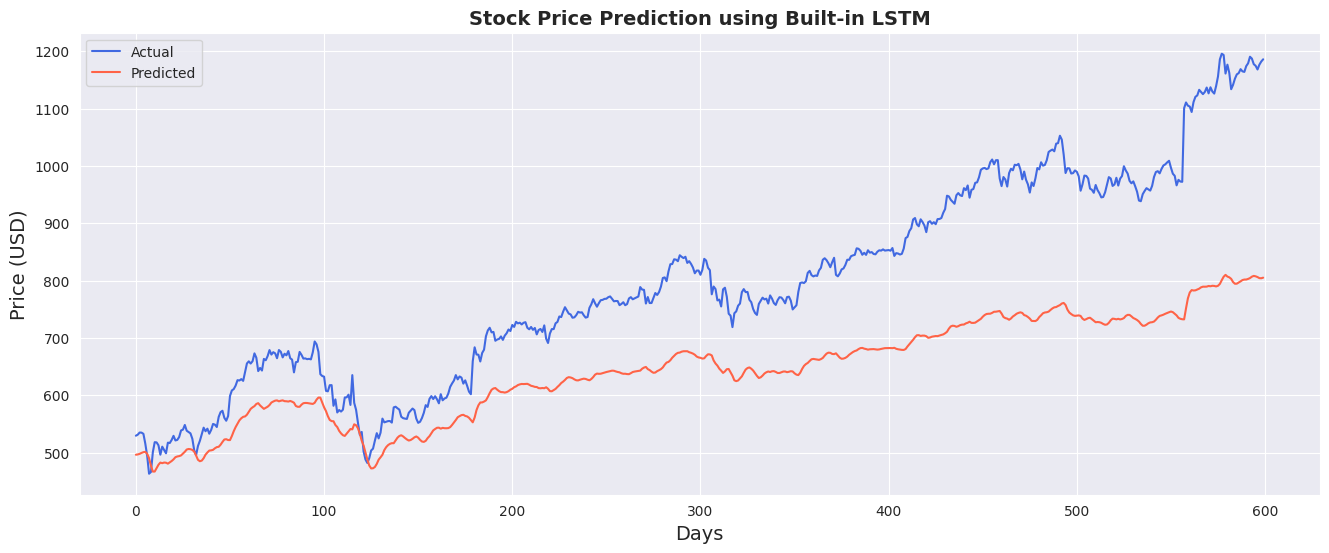

Train RMSE: 0.01
Test RMSE: 0.30


In [ ]:
# Convert to torch Tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Built-in LSTM model
class LSTMNetBuiltIn(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMNetBuiltIn, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output at the last time step
        return out

# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 1
num_epochs = 100
learning_rate = 0.01

# Initialize the model, criterion, and optimizer
model_lstm = LSTMNetBuiltIn(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

# Training loop
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

for t in range(num_epochs):
    y_train_pred = model_lstm(x_train)
    loss = criterion(y_train_pred, y_train)

    print(f"LSTM Epoch {t+1}/{num_epochs}, MSE: {loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test data
with torch.no_grad():
    y_test_pred = model_lstm(x_test)

# Plot predictions
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.cpu().numpy()))

plt.figure(figsize=(16, 6))
sns.lineplot(x=original_test.index, y=original_test[0], label="Actual", color="royalblue")
sns.lineplot(x=predict_test.index, y=predict_test[0], label="Predicted", color="tomato")
plt.title("Stock Price Prediction using Built-in LSTM", fontsize=14, fontweight="bold")
plt.xlabel("Days", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.show()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train.cpu().numpy(), model_lstm(x_train).cpu().detach().numpy()))
test_rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), y_test_pred.cpu().numpy()))
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


## 6 - Built-in GRU

Use the provided code snippets and train a 1-layer GRU network using the PyTorch built-in GRU cell. Please show the prediction plots as well as the MSE on both training and testing data.

GRU Epoch 0, MSE: 0.3770807385444641
GRU Epoch 1, MSE: 0.11883964389562607
GRU Epoch 2, MSE: 0.02333950623869896
GRU Epoch 3, MSE: 0.1046367958188057
GRU Epoch 4, MSE: 0.028384270146489143
GRU Epoch 5, MSE: 0.024542251601815224
GRU Epoch 6, MSE: 0.044454656541347504
GRU Epoch 7, MSE: 0.052305806428194046
GRU Epoch 8, MSE: 0.0449254997074604
GRU Epoch 9, MSE: 0.030503224581480026
GRU Epoch 10, MSE: 0.01859365589916706
GRU Epoch 11, MSE: 0.01568211428821087
GRU Epoch 12, MSE: 0.021317122504115105
GRU Epoch 13, MSE: 0.02755715698003769
GRU Epoch 14, MSE: 0.026928098872303963
GRU Epoch 15, MSE: 0.02034670300781727
GRU Epoch 16, MSE: 0.01388967502862215
GRU Epoch 17, MSE: 0.011717075482010841
GRU Epoch 18, MSE: 0.01357545331120491
GRU Epoch 19, MSE: 0.016453636810183525
GRU Epoch 20, MSE: 0.01739305630326271
GRU Epoch 21, MSE: 0.015402030199766159
GRU Epoch 22, MSE: 0.011703568510711193
GRU Epoch 23, MSE: 0.008642968721687794
GRU Epoch 24, MSE: 0.007960149087011814
GRU Epoch 25, MSE: 0.0093

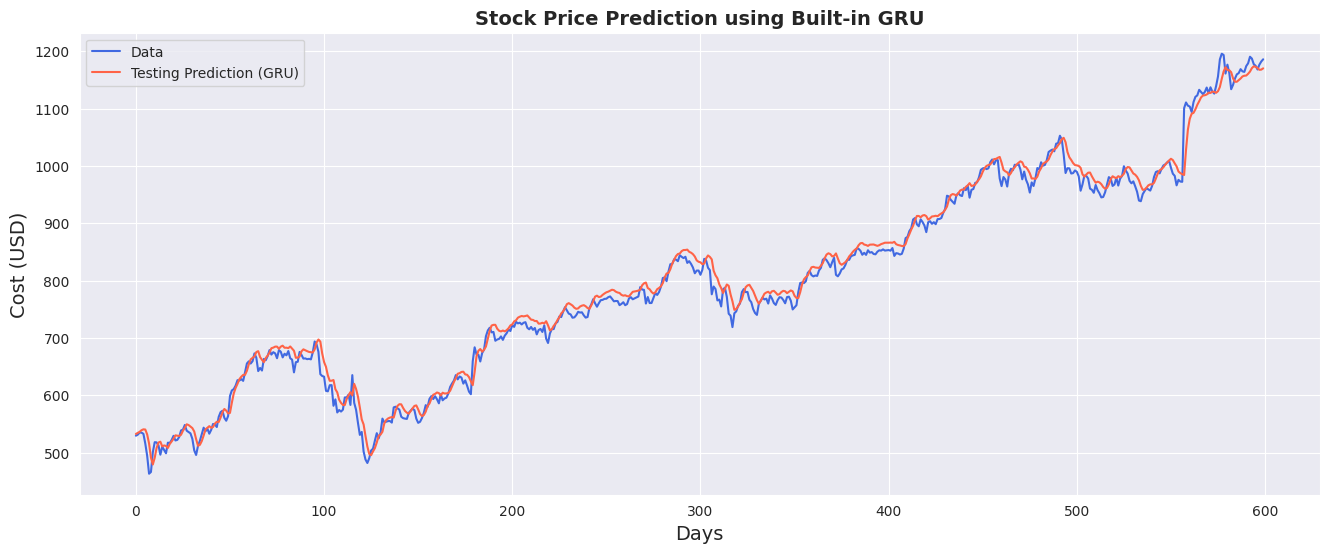

Train RMSE: 0.01
Test RMSE: 0.03


In [ ]:
# Built-in GRU Implementation
class GRUNetBuiltIn(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUNetBuiltIn, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the output at the last time step
        return out

# Initialize and train the model
model_gru = GRUNetBuiltIn(input_dim, hidden_dim, output_dim, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

# Training loop
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model_gru(x_train)
    loss = criterion(y_train_pred, y_train)

    print(f"GRU Epoch {t}, MSE: {loss.item()}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Predictions
with torch.no_grad():
    y_test_pred = model_gru(x_test.to(device))

# Plot predictions
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.cpu().numpy()))

plt.figure(figsize=(16, 6))
sns.lineplot(x=original_test.index, y=original_test[0], label="Data", color="royalblue")
sns.lineplot(x=predict_test.index, y=predict_test[0], label="Testing Prediction (GRU)", color="tomato")
plt.title("Stock Price Prediction using Built-in GRU", fontsize=14, fontweight="bold")
plt.xlabel("Days", fontsize=14)
plt.ylabel("Cost (USD)", fontsize=14)
plt.show()

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train.cpu().numpy(), model_gru(x_train).cpu().detach().numpy()))
test_rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), y_test_pred.cpu().numpy()))
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
